# Visualise convolution kernels - MNIST

In [1]:
import matplotlib.pyplot as plt
import math
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Set up the network

The network is copied from the official Tensorflow documentation.

In [2]:
# Copyright 2015 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

"""A deep MNIST classifier using convolutional layers.

See extensive documentation at
https://www.tensorflow.org/get_started/mnist/pros
"""
# Disable linter warnings to maintain consistency with tutorial.
# pylint: disable=invalid-name
# pylint: disable=g-bad-import-order

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys
import tempfile

from tensorflow.examples.tutorials.mnist import input_data

import tensorflow as tf

FLAGS = None


def deepnn(x):
  """deepnn builds the graph for a deep net for classifying digits.

  Args:
    x: an input tensor with the dimensions (N_examples, 784), where 784 is the
    number of pixels in a standard MNIST image.

  Returns:
    A tuple (y, keep_prob). y is a tensor of shape (N_examples, 10), with values
    equal to the logits of classifying the digit into one of 10 classes (the
    digits 0-9). keep_prob is a scalar placeholder for the probability of
    dropout.
  """
  # Reshape to use within a convolutional neural net.
  # Last dimension is for "features" - there is only one here, since images are
  # grayscale -- it would be 3 for an RGB image, 4 for RGBA, etc.
  with tf.name_scope('reshape'):
    x_image = tf.reshape(x, [-1, 28, 28, 1])

  # First convolutional layer - maps one grayscale image to 32 feature maps.
  with tf.name_scope('conv1'):
    W_conv1 = weight_variable([5, 5, 1, 32])
    b_conv1 = bias_variable([32])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

  # Pooling layer - downsamples by 2X.
  with tf.name_scope('pool1'):
    h_pool1 = max_pool_2x2(h_conv1)

  # Second convolutional layer -- maps 32 feature maps to 64.
  with tf.name_scope('conv2'):
    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

  # Second pooling layer.
  with tf.name_scope('pool2'):
    h_pool2 = max_pool_2x2(h_conv2)

  # Fully connected layer 1 -- after 2 round of downsampling, our 28x28 image
  # is down to 7x7x64 feature maps -- maps this to 1024 features.
  with tf.name_scope('fc1'):
    W_fc1 = weight_variable([7 * 7 * 64, 1024])
    b_fc1 = bias_variable([1024])

    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

  # Dropout - controls the complexity of the model, prevents co-adaptation of
  # features.
  with tf.name_scope('dropout'):
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

  # Map the 1024 features to 10 classes, one for each digit
  with tf.name_scope('fc2'):
    W_fc2 = weight_variable([1024, 10])
    b_fc2 = bias_variable([10])

    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
  return y_conv, keep_prob


def conv2d(x, W):
  """conv2d returns a 2d convolution layer with full stride."""
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
  """max_pool_2x2 downsamples a feature map by 2X."""
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')


def weight_variable(shape):
  """weight_variable generates a weight variable of a given shape."""
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)


def bias_variable(shape):
  """bias_variable generates a bias variable of a given shape."""
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

In [4]:
# Import data
mnist = input_data.read_data_sets("MNIST-data", one_hot=True)
#mnist = tf.contrib.learn.datasets.load_dataset("mnist")

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [5]:
# Create the model
x = tf.placeholder(tf.float32, [None, 784])

# Define loss and optimizer
y_ = tf.placeholder(tf.float32, [None, 10])

# Build the graph for the deep net
y_conv, keep_prob = deepnn(x)

with tf.name_scope('loss'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_,
                                                            logits=y_conv)
cross_entropy = tf.reduce_mean(cross_entropy)

with tf.name_scope('adam_optimizer'):
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
    correct_prediction = tf.cast(correct_prediction, tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)

#graph_location = tempfile.mkdtemp()
graph_location = '/home/docker/aimotive/tf_log'
print('Saving graph to: %s' % graph_location)
train_writer = tf.summary.FileWriter(graph_location)
train_writer.add_graph(tf.get_default_graph())

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(200):
      batch = mnist.train.next_batch(50)
      if i % 100 == 0:
        train_accuracy = accuracy.eval(feed_dict={
            x: batch[0], y_: batch[1], keep_prob: 1.0})
        print('step %d, training accuracy %g' % (i, train_accuracy))
      train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

    print('test accuracy %g' % accuracy.eval(feed_dict={
        x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

Saving graph to: /home/docker/aimotive/tf_log
step 0, training accuracy 0.1
step 100, training accuracy 0.88
test accuracy 0.9084


In [6]:
g = tf.get_default_graph()

# Plot the filters and the activations

Plot the filters used for the convolution and plot the activations generated by these filters for a single selected input image.

Note that the network has not been fully trained (it has barely moved from the random initial state), so the kernels are random and the activations do not mean much. This notebook was only used to test the visualisations before moving on to using the final selected network.

In [36]:
def getActivations(layer, stimuli):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        g = tf.get_default_graph()
        # Get the input and output tensors so we can feed them
        # Equivalent to: g.get_tensor_by_name('a:0')
        output_tensor = g.get_operation_by_name(layer).outputs[0]
        input_tensor = g.get_operation_by_name('Placeholder').outputs[0]

        units = sess.run(output_tensor, feed_dict={input_tensor: img, keep_prob:1.0})
        plotActivations(units)

def plotActivations(units):
    if (len(units.shape) > 2):
        filters = units.shape[3]
        plt.figure(1, figsize=(20,20))
        n_columns = 6
        n_rows = math.ceil(filters / n_columns) + 1
        for i in range(filters):
            plt.subplot(n_rows, n_columns, i+1)
            plt.title('Filter ' + str(i))
            plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")
    else:
        plt.imshow(units, interpolation="nearest", cmap="gray")

def getFilters(layer):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        g = tf.get_default_graph()
        filter_tensor = g.get_operation_by_name(layer).inputs[1]

        filters = filter_tensor.eval()
        plotFilters(filters)

def plotFilters(units):
    if (len(units.shape) > 2):
        filters = units.shape[3]
        plt.figure(1, figsize=(20,20))
        n_columns = 6
        n_rows = math.ceil(filters / n_columns) + 1
        for i in range(filters):
            plt.subplot(n_rows, n_columns, i+1)
            plt.title('Filter ' + str(i))
            plt.imshow(units[:,:,0,i], interpolation="nearest", cmap="gray")
    else:
        plt.imshow(units, interpolation="nearest", cmap="gray")

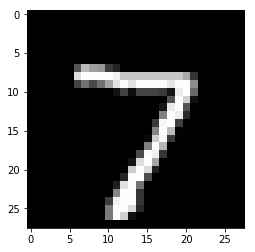

In [8]:
img = mnist.test.images[[0]]
plt.imshow(np.reshape(img, [28,28]), interpolation="nearest", cmap="gray")

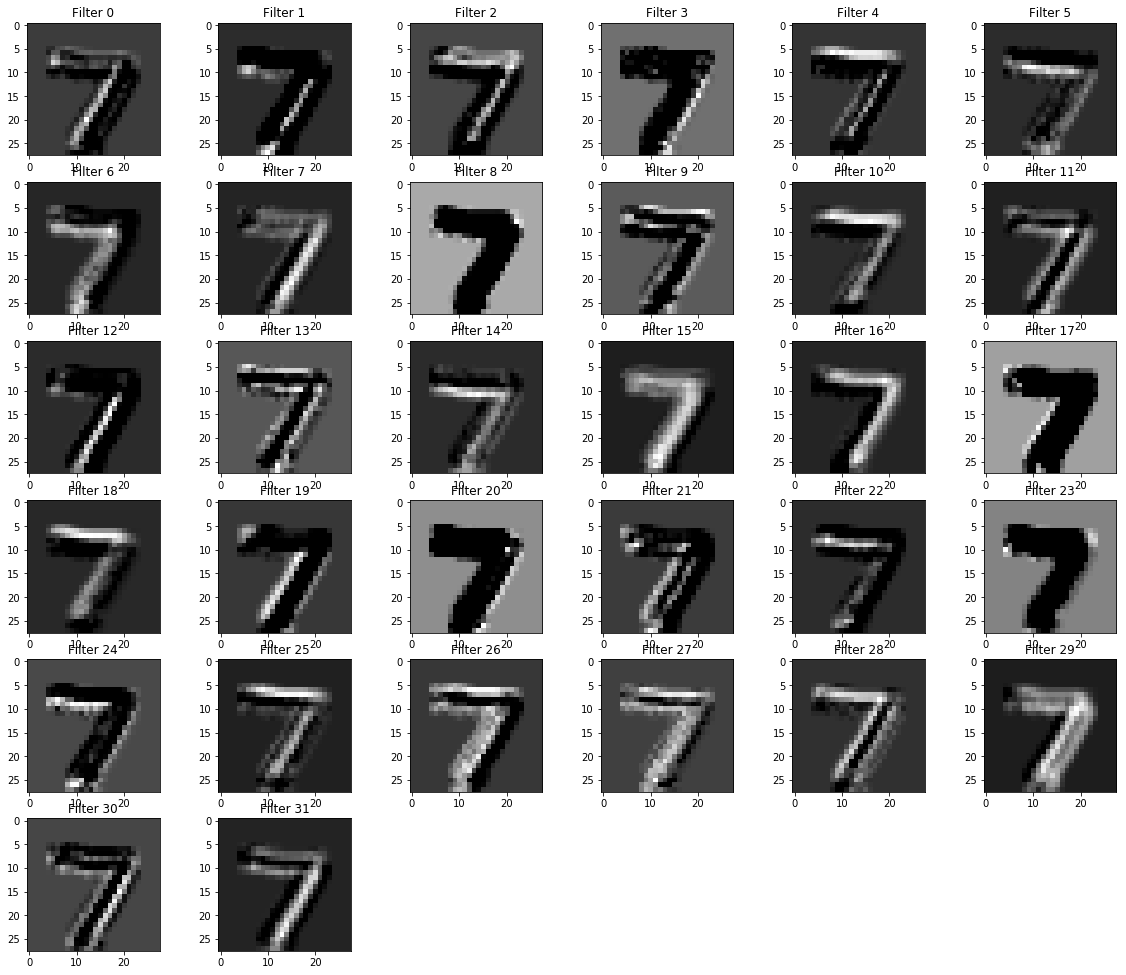

In [29]:
getActivations('conv1/Relu', img)

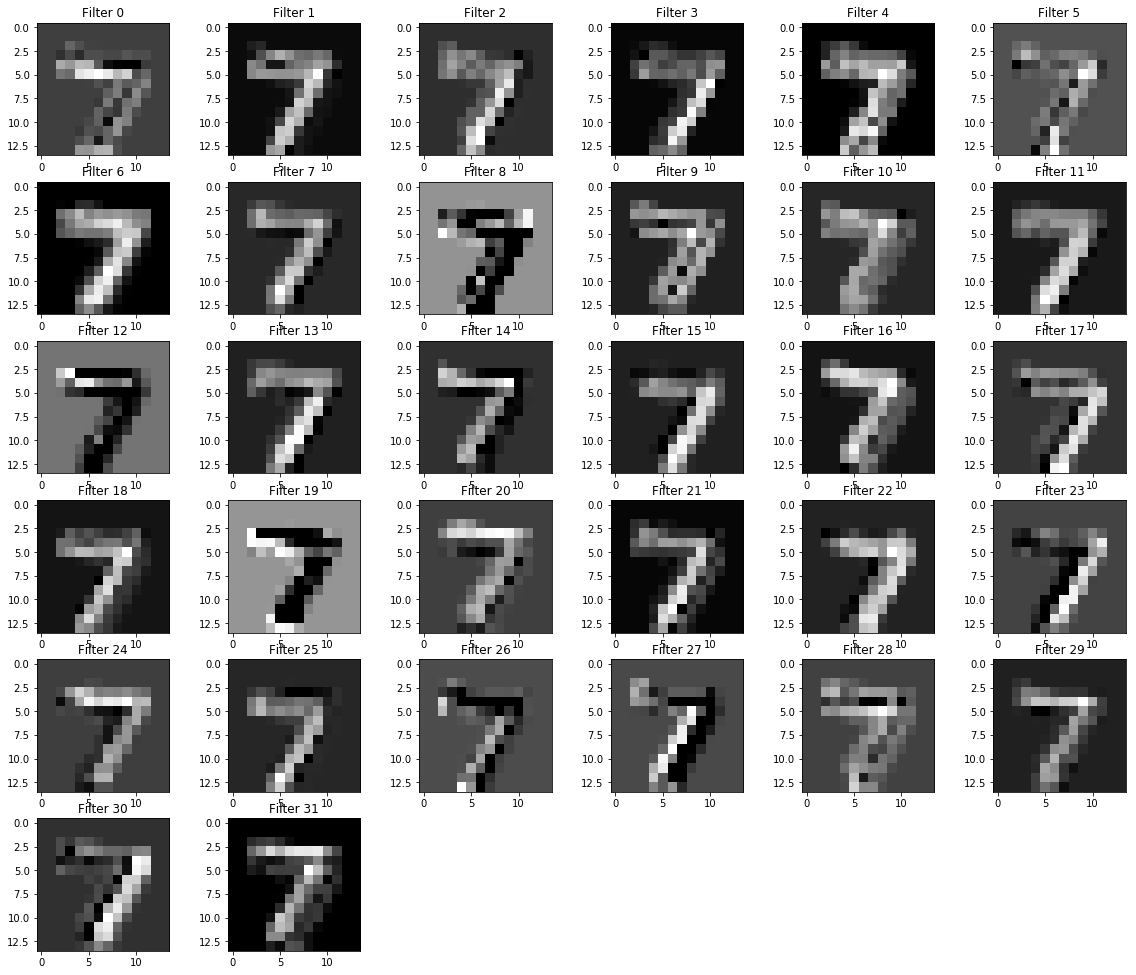

In [30]:
getActivations('pool1/MaxPool', img)

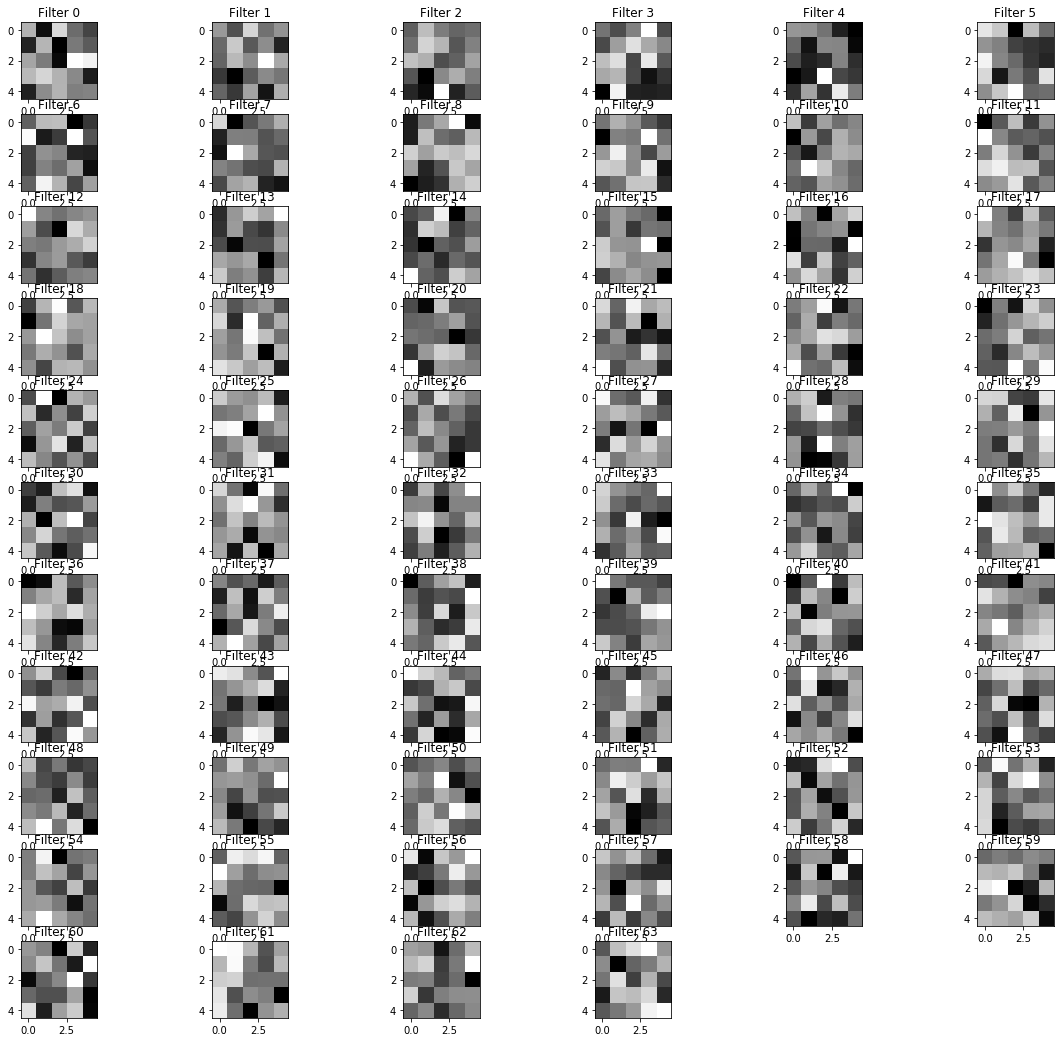

In [37]:
getFilters('conv2/Conv2D')